In [1]:
from py_linkedin import *
from py_labeling import *
from py_db import *

All that's left now is to create a function that checks all the job posts in my LinkedIn alerts and filters out the ones that I want based on the analysis I've performed.

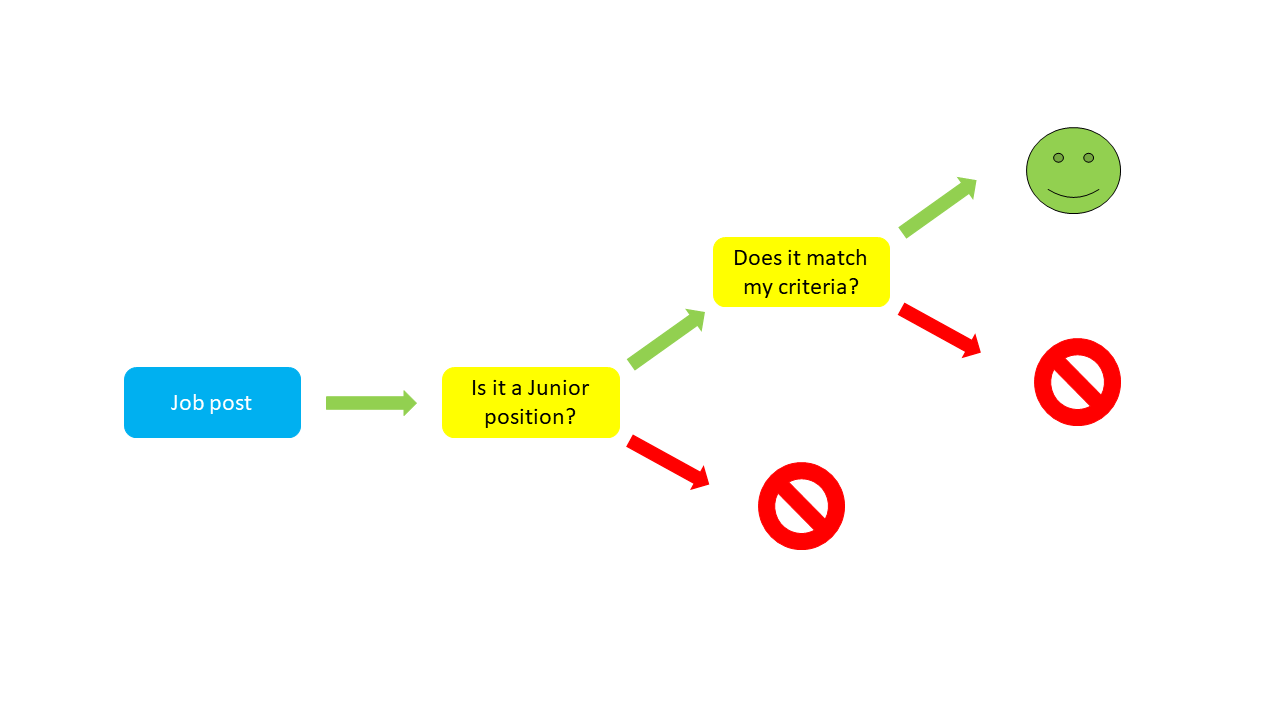

The function below will create two arrays, one to store the jobs I am a good match for and one for the ones that I am not a good match for. Then it will save this information in two separate tables in our database!

In [2]:
def job_classification(job_alerts:list):
    
    #model
    classifier = Bert_for_zero_shot_classification()
    #tresholds
    with open("tresholds.json", "r") as f:
        tresholds = json.load(f)
        treshold_python = tresholds["python"]
        treshold_analyst = tresholds["analytics"]
        treshold_sql = tresholds["sql"]
        treshold_junior = tresholds["junior"]
        treshold_overall = tresholds["overall"]
    #ids already analysed
    duplicates = pd.concat([sql_query_to_pandas("SELECT job_id FROM jobs_good_match"), 
                    sql_query_to_pandas("SELECT job_id FROM jobs_not_good_match")])
    
    #info array
    good_match = []
    not_good_match = []
    
    #job alerts loop
    for job_alert in job_alerts:
        driver = linkedin_job_alerts()
        content = driver.find_elements(By.TAG_NAME, "body")[0]
        get_job_alert_page(content, job_alert)
        content = driver.find_elements(By.TAG_NAME, "body")[0]
        
        #results page loop setup
        next_page = 2
        total_pages = get_job_results_page_buttons_total_number(content)
        next_page_button = get_next_page_job_button(content, next_page)      
        while next_page <= total_pages:
            
            #jobs on page loop
            job_posts_container = job_posts_on_page(content)
            job_count = 1
            skipped = 0
            for job_element in job_posts_container:
                print(f"Getting {job_alert} jobs. Page {next_page - 1} of {total_pages}. Job {job_count} of {len(job_posts_container)}...                       ", 
                    end = "\r", flush = True)
                try:
                    job_element.click()
                    time.sleep(random.randint(14, 23) / 10)
                    content = driver.find_elements(By.TAG_NAME, "body")[0]
                    job_id, job_description, job_url = get_job_info(content)
        
                    #avoiding duplication
                    if job_id in duplicates.values:
                        job_count += 1
                        skipped += 1
                        pass
                    else:
                        score_python = pipe(classifier, "python", job_description)
                        score_analyst = pipe(classifier, "data analysis" , job_description)
                        score_sql = pipe(classifier, "sql", job_description)
                        score_junior = pipe(classifier, "junior level", job_description)
                        score_overall = 3*score_python + 1.5*score_analyst + score_sql
                        row = [job_id, job_description, job_url, score_python, score_analyst, score_sql, score_junior, score_overall]

                        #classifying the data
                        if score_python >= treshold_python and score_junior >= treshold_junior:
                            good_match.append(row)
                        elif score_overall >= treshold_overall and score_junior >= treshold_junior:
                            good_match.append(row)
                        elif score_analyst >= treshold_analyst and score_junior >= treshold_junior:
                            good_match.append(row)
                        elif score_sql >= treshold_sql and score_junior >= treshold_junior:
                            good_match.append(row)
                        else:
                            not_good_match.append(row)
                        job_count += 1  
                except:
                    job_count += 1
                    pass
            #avoiding unnecessary loops
            if skipped == len(job_posts_container):
                print("\n", "We already have all these jobs... Exiting...", sep = "")
                break
                
            #results page loop end        
            try:
                next_page_button.click()
                next_page += 1
                time.sleep(random.randint(20, 27) / 10)
                content = driver.find_elements(By.TAG_NAME, "body")[0]
                next_page_button = get_next_page_job_button(content, next_page)
            except:
                next_page += 1
                
    #storing data            
    colnames = ["job_id", "job_description", "job_url", "score_python", "score_analyst", "score_sql", "score_junior", "score_overall"]   
    print("\n", "\n", sep = "")

    if len(good_match) != 0:
        good_match_df = pd.DataFrame(good_match, columns = colnames)
        good_match_df.drop_duplicates(subset = ["job_id"], keep = 'first', inplace = True)
        pandas_to_mysql(good_match_df, "jobs_good_match", if_exists = "append")

    if len(not_good_match) != 0:
        not_good_match_df = pd.DataFrame(not_good_match, columns = colnames)
        not_good_match_df.drop_duplicates(subset = ["job_id"], keep = 'first', inplace = True)
        pandas_to_mysql(not_good_match_df, "jobs_not_good_match", if_exists = "append")

In [3]:
job_classification(["data scientist", "data analyst", "data engineer"])

C:\Users\Ruben\anaconda3\envs\linkedin\lib\site-packages\transformers\pipelines\base.py:1073: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


Getting data scientist jobs. Page 22 of 40. Job 25 of 25...                       
We already have all these jobs... Exiting...
Getting data analyst jobs. Page 32 of 40. Job 25 of 25...                       
We already have all these jobs... Exiting...
Getting data engineer jobs. Page 39 of 40. Job 25 of 25...                       


52 entries were added to the table jobs_good_match!
1206 entries were added to the table jobs_not_good_match!


All that's left now is to apply for these jobs!